### Importing libraries and data

In [2]:
# Importing Libraries 
import pandas as pd
# import dowhy
import numpy as np

In [3]:
# Importing the data
df_accepted = pd.read_csv('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/data/df_trip_processed.csv')
df_rejected = pd.read_csv('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/data/rejected.csv')
df_accepted = df_accepted.drop(columns=['Unnamed: 0'])
df_rejected = df_rejected.drop(columns=['Unnamed: 0'])

### Merging the data

In [4]:

df_rejected.drop(columns=['id'], inplace=True)
df_accepted.drop(columns=['speed_kmh','distance_km','time_hours','trip_end_time','lat_des','lon_des'], inplace=True)
df_accepted[['date', 'time']] = df_accepted['trip_start_time'].str.split(' ', expand=True)
df_accepted.drop(columns=['time'], inplace=True)
df_accepted.drop(columns=['trip_start_time'], inplace=True)
df_accepted.rename(columns={'Trip ID': 'order_id'}, inplace=True)
df_accepted.rename(columns={'lat_org': 'lat'}, inplace=True)
df_accepted.rename(columns={'lon_org': 'lng'}, inplace=True)
df_accepted['driver_action']= 'accepted'
df_concatenated = pd.concat([df_accepted, df_rejected], axis=0, ignore_index=True)

### Adding mean Distance 
I calculated the mean latitude and longtiude from the data. Then I calculated the distance of each location from this mean location.

In [5]:
lat_mean = df_concatenated['lat'].mean()
lon_mean = df_concatenated['lng'].mean()

In [6]:
# Function to calculate the distance using latitude and longtiude 

from math import radians, sin, cos, sqrt, atan2
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Calculate the differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Calculate the distance using the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance
# Calculating the distance of each order to the mean loaction
df_concatenated['distance_to_centroid_km'] = df_concatenated.apply(lambda row: haversine_distance(row['lat'], row['lng'], lat_mean, lon_mean), axis=1)

In [7]:
df_concatenated

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,driver_id,distance_to_centroid_km
0,rain,391996,6.508813,3.377403,No holiday,Weekday,2021-07-01,accepted,NaN,2.900766
1,rain,391997,6.431671,3.455538,No holiday,Weekday,2021-07-01,accepted,NaN,13.903867
2,rain,391998,6.631679,3.338898,No holiday,Weekday,2021-07-01,accepted,NaN,11.906831
3,rain,391999,6.572757,3.367708,No holiday,Weekday,2021-07-01,accepted,NaN,4.629181
4,rain,392001,6.601042,3.276634,No holiday,Weekday,2021-07-01,accepted,NaN,13.949293
...,...,...,...,...,...,...,...,...,...,...
2064210,rain,517948,6.469036,3.566877,No holiday,Weekday,2021-09-10,rejected,243774.0,21.517140
2064211,rain,517948,6.425431,3.527358,No holiday,Weekday,2021-09-10,rejected,245447.0,19.972931
2064212,rain,517948,6.440013,3.525378,No holiday,Weekday,2021-09-10,rejected,239866.0,18.852522
2064213,rain,517948,6.469036,3.566877,No holiday,Weekday,2021-09-10,rejected,243774.0,21.517140


## Filtering orders
Since the rejected orders are accepted by other drivers, we can analyze those orders to identify causality. By examining the orders that were initially rejected but then accepted by other drivers, we may be able to uncover the underlying reasons or patterns that led to the initial rejection. This analysis could provide valuable insights to improve the order allocation process and reduce the number of rejected orders in the future.

In [8]:
# Step 1: Identify the duplicated values in the specified column
duplicated_values = df_concatenated['order_id'][df_concatenated['order_id'].duplicated()].unique()

# Step 2: Filter the DataFrame to get rows with these duplicated values
filtered_df = df_concatenated[df_concatenated['order_id'].isin(duplicated_values)]
filtered_df

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,driver_id,distance_to_centroid_km
4,rain,392001,6.601042,3.276634,No holiday,Weekday,2021-07-01,accepted,NaN,13.949293
5,rain,392005,6.565088,3.384441,No holiday,Weekday,2021-07-01,accepted,NaN,3.437264
6,rain,392009,6.663648,3.308206,No holiday,Weekday,2021-07-01,accepted,NaN,16.624263
7,rain,392013,6.430817,3.434155,No holiday,Weekday,2021-07-01,accepted,NaN,12.785234
8,rain,392014,6.499156,3.358517,No holiday,Weekday,2021-07-01,accepted,NaN,4.773427
...,...,...,...,...,...,...,...,...,...,...
2064210,rain,517948,6.469036,3.566877,No holiday,Weekday,2021-09-10,rejected,243774.0,21.517140
2064211,rain,517948,6.425431,3.527358,No holiday,Weekday,2021-09-10,rejected,245447.0,19.972931
2064212,rain,517948,6.440013,3.525378,No holiday,Weekday,2021-09-10,rejected,239866.0,18.852522
2064213,rain,517948,6.469036,3.566877,No holiday,Weekday,2021-09-10,rejected,243774.0,21.517140


In [12]:
filtered_df[filtered_df['driver_action']=='accepted']

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,driver_id,distance_to_centroid_km
4,rain,392001,6.601042,3.276634,No holiday,Weekday,2021-07-01,accepted,NaN,13.949293
5,rain,392005,6.565088,3.384441,No holiday,Weekday,2021-07-01,accepted,NaN,3.437264
6,rain,392009,6.663648,3.308206,No holiday,Weekday,2021-07-01,accepted,NaN,16.624263
7,rain,392013,6.430817,3.434155,No holiday,Weekday,2021-07-01,accepted,NaN,12.785234
8,rain,392014,6.499156,3.358517,No holiday,Weekday,2021-07-01,accepted,NaN,4.773427
...,...,...,...,...,...,...,...,...,...,...
181205,partly-cloudy-day,497721,6.482082,3.382865,No holiday,Weekend,2021-09-04,accepted,NaN,5.794554
197289,rain,517948,6.443374,3.552312,No holiday,Weekday,2021-09-10,accepted,NaN,21.210402
534289,clear-day,510268,6.449419,3.401645,No holiday,Weekday,2022-01-21,accepted,NaN,9.637279
534304,partly-cloudy-day,489898,6.442073,3.478872,No holiday,Weekday,2022-02-04,accepted,NaN,14.696037


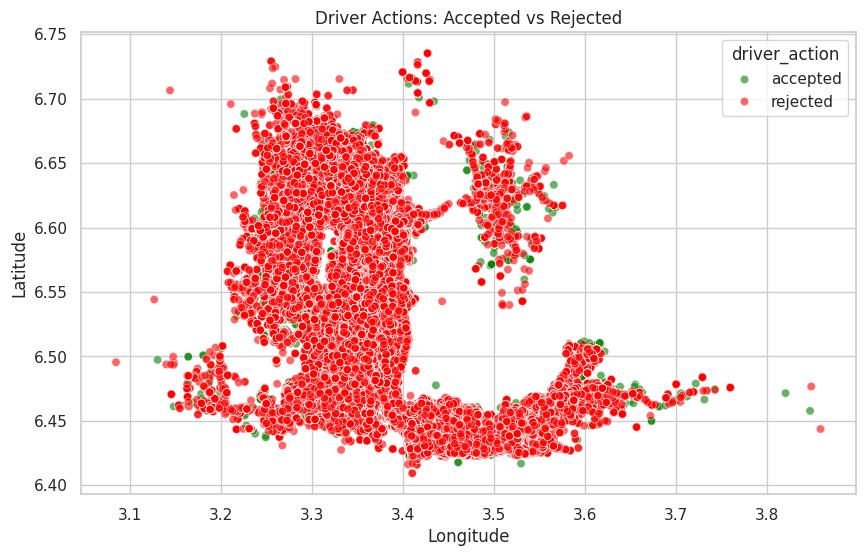

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the visualization
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_df, 
    x='lng', 
    y='lat', 
    hue='driver_action', 
    palette={'accepted': 'green', 'rejected': 'red'},
    alpha=0.6
)

# Add titles and labels
plt.title('Driver Actions: Accepted vs Rejected')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()


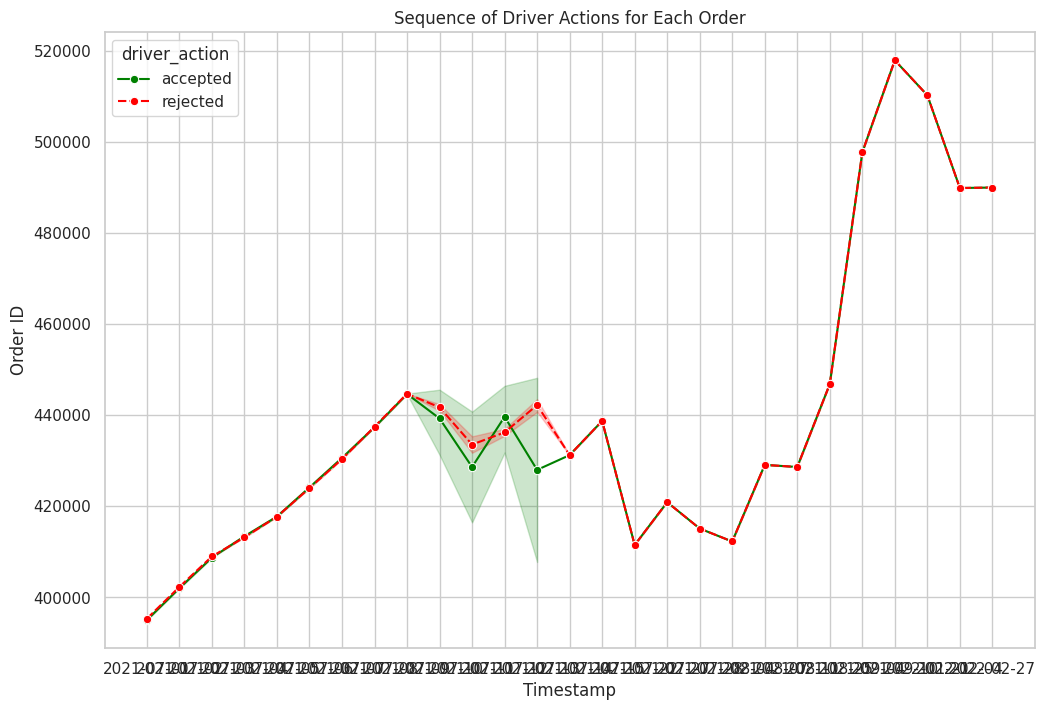

In [14]:
sns.set(style="whitegrid")

# Create a lineplot to show the sequence of rejections and acceptance for each order
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=filtered_df, 
    x='date', 
    y='order_id', 
    hue='driver_action', 
    marker='o', 
    style='driver_action',
    palette={'accepted': 'green', 'rejected': 'red'}
)

# Add titles and labels
plt.title('Sequence of Driver Actions for Each Order')
plt.xlabel('Timestamp')
plt.ylabel('Order ID')

# Show plot
plt.show()

In [16]:
# Group by order_id and calculate the number of rejections before acceptance
rejection_counts = filtered_df[filtered_df['driver_action'] == 'rejected'].groupby('order_id').size().reset_index(name='num_rejections')

# Merge with the original DataFrame to get orders that have an acceptance
accepted_orders = filtered_df[filtered_df['driver_action'] == 'accepted'][['order_id']].drop_duplicates()
summary_df = pd.merge(rejection_counts, accepted_orders, on='order_id', how='right').fillna(0)

summary_df['num_rejections'] = summary_df['num_rejections'].astype(int)
summary_df


,order_id,num_rejections
0,392001,9
1,392005,50
2,392009,66
3,392013,12
4,392014,4
...,...,...
25329,497721,2
25330,517948,62
25331,510268,3
25332,489898,19


In [17]:
total_orders = filtered_df['order_id'].nunique()
accepted_orders_count = summary_df['order_id'].nunique()
rejected_orders_count = total_orders - accepted_orders_count
average_rejections_before_acceptance = summary_df['num_rejections'].mean()

statistics = {
    'Total Orders': total_orders,
    'Accepted Orders': accepted_orders_count,
    'Rejected Orders': rejected_orders_count,
    'Average Rejections Before Acceptance': average_rejections_before_acceptance
}

statistics


{'Total Orders': 25334,
 'Accepted Orders': 25334,
 'Rejected Orders': 0,
 'Average Rejections Before Acceptance': 60.38710823399384}

### Using CausalNex 

### Casual Inferance
I am usig dowhy to generate 

create an empty structure model.

In [18]:

import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

In [10]:
sm.add_edges_from([
    ('holiday_name', 'driver_action'),
    ('day_type', 'driver_action')
])

In [11]:
sm.edges

OutEdgeView([('holiday_name', 'driver_action'), ('day_type', 'driver_action')])

In [12]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_simple_plot.html')

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_simple_plot.html


In [21]:
df_concatenated.columns

Index(['icon', 'holiday_name', 'day_type', 'date', 'driver_action',
       'distance_to_centroid_km'],
      dtype='object')

In [ ]:

drop_col = ['order_id','lat','lng','driver_id']
data = df_concatenated.drop(columns=drop_col,inplace=True)
data

In [38]:
data = df_concatenated
data

,icon,holiday_name,day_type,date,driver_action,distance_to_centroid_km
0,rain,No holiday,Weekday,2021-07-01,accepted,2.900766
1,rain,No holiday,Weekday,2021-07-01,accepted,13.903867
2,rain,No holiday,Weekday,2021-07-01,accepted,11.906831
3,rain,No holiday,Weekday,2021-07-01,accepted,4.629181
4,rain,No holiday,Weekday,2021-07-01,accepted,13.949293
...,...,...,...,...,...,...
2064210,rain,No holiday,Weekday,2021-09-10,rejected,21.517140
2064211,rain,No holiday,Weekday,2021-09-10,rejected,19.972931
2064212,rain,No holiday,Weekday,2021-09-10,rejected,18.852522
2064213,rain,No holiday,Weekday,2021-09-10,rejected,21.517140


In [39]:

import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['icon', 'holiday_name', 'day_type', 'date', 'driver_action']


In [40]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,icon,holiday_name,day_type,date,driver_action,distance_to_centroid_km
0,2,18,0,0,0,2.900766
1,2,18,0,0,0,13.903867
2,2,18,0,0,0,11.906831
3,2,18,0,0,0,4.629181
4,2,18,0,0,0,13.949293


In [41]:
struct_data[struct_data['driver_action']==1]

,icon,holiday_name,day_type,date,driver_action,distance_to_centroid_km
534368,2,18,0,0,1,12.410538
534369,2,18,0,0,1,13.178045
534370,2,18,0,0,1,13.297170
534371,2,18,0,0,1,13.380191
534372,2,18,0,0,1,12.438900
...,...,...,...,...,...,...
2064210,2,18,0,71,1,21.517140
2064211,2,18,0,71,1,19.972931
2064212,2,18,0,71,1,18.852522
2064213,2,18,0,71,1,21.517140


In [42]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data)

In [43]:

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_fully_connected.html")

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_fully_connected.html


In [44]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_thresholded.html")

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_thresholded.html


In [15]:
g = """digraph {

icon;
holiday_name;
day_type;
date;
driver_action;
distance_to_centroid_km;

icon -> driver_action;
holiday_name -> driver_action;
day_type -> driver_action;
date -> driver_action;
distance_to_centroid_km -> driver_action;

}"""

In [104]:
df_sample = df_concatenated.sample(n=200, random_state=42)
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,Weekend,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,Weekday,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,Weekday,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,Weekday,2021-07-01,rejected,139750.0,242884.0,5.602618


In [49]:
# Convert 'holiday_name' to numeric based on condition
# Assuming df_sample is your DataFrame with 'driver_action' column
df_sample['driver_action'] = np.where(df_sample['driver_action'] == 'rejected', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['driver_action'] = df_sample['driver_action'].astype(int)

print(df_sample)

                      icon  order_id       lat       lng holiday_name  \
1888836               rain    436877  6.433474  3.494433   No holiday   
1709785               rain    430013  6.526287  3.367707   No holiday   
1511112  partly-cloudy-day    425319  6.518392  3.353533   No holiday   
246953                rain    944862  6.481890  3.369439   No holiday   
943402                rain    407957  6.596473  3.338337   No holiday   
251073   partly-cloudy-day    953229  6.594051  3.341678   No holiday   
926041                rain    407222  6.557803  3.360702   No holiday   
1046706               rain    412175  6.665881  3.373062   No holiday   
419902                rain   1322630  6.525837  3.395278   No holiday   
651944                rain    396889  6.567582  3.367077   No holiday   
505372   partly-cloudy-day   1526213  6.501229  3.353544   No holiday   
849589                rain    404337  6.544338  3.363482   No holiday   
844286                rain    404178  6.600522  3.3

In [87]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,Weekend,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,Weekday,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,Weekday,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,Weekday,2021-07-01,rejected,139750.0,242884.0,5.602618


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import sklearn

def preprocess_data(data):
    # Fill missing values
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Encode categorical variables (including strings)
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    
    # Check the version of scikit-learn
    sklearn_version = sklearn.__version__
    if sklearn_version < "1.2.0":
        encoder = OneHotEncoder(drop='first', sparse=False)
    else:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    # Apply OneHotEncoder to categorical columns
    encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))
    encoded_data.columns = encoder.get_feature_names_out(categorical_cols)
    encoded_data.index = data.index
    
    # Drop original categorical columns and concatenate the encoded columns
    data = data.drop(categorical_cols, axis=1)
    data = pd.concat([data, encoded_data], axis=1)
    
    # Ensure all data is numeric
    data = data.apply(pd.to_numeric)
    
    return data

# Assuming `df` is your DataFrame
data = preprocess_data(df_head)

# Check the data types to ensure they are all numeric
print(data.dtypes)

order_id                     int64
lat                        float64
lng                        float64
driver_id                  float64
distance_to_centroid_km    float64
dtype: object


/tmp/ipykernel_231698/711918826.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [84]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,1,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,1,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,1,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,1,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,1,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,1,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,1,2021-07-01,rejected,139750.0,242884.0,5.602618


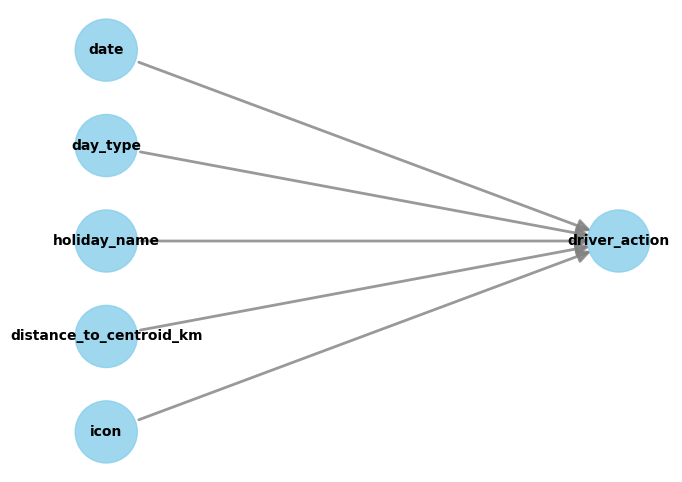

In [22]:
from dowhy import CausalModel

treatment_col = 'day_type'
outcome_col = 'driver_action'
model2=CausalModel(
    data = df_sample,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=g)

model2.view_model()

In [23]:
identified_estimand = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)  # Explore methods proposed

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
───────────(E[driver_action])
d[day_type]                  
Estimand assumption 1, Unconfoundedness: If U→{day_type} and U→driver_action then P(driver_action|day_type,,U) = P(driver_action|day_type,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [128]:
df_sample[self._target_estimand.treatment_variable]


NameError: name 'self' is not defined

In [25]:
#method = "backdoor.propensity_score_weighting"
method = "backdoor.linear_regression"

desired_effect = "ate"

estimate = model2.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,                         
    method_params={"weighting_scheme":"ips_weight"})

print("Causal Estimate is " + str(estimate.value))

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


ValueError: Found unknown categories [1] in column 0 during transform

In [38]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,0,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,0,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,0,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,1,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,0,416976.0,195104.0,8.534560
251073,partly-cloudy-day,953229,6.594051,3.341678,No holiday,Weekday,2021-09-29,1,NaN,NaN,8.101650
926041,rain,407222,6.557803,3.360702,No holiday,Weekend,2021-07-03,0,399245.0,243899.0,3.637285
1046706,rain,412175,6.665881,3.373062,No holiday,Weekend,2021-07-04,0,522057.0,244122.0,14.688552
419902,rain,1322630,6.525837,3.395278,No holiday,Weekday,2021-11-22,1,NaN,NaN,1.599771
651944,rain,396889,6.567582,3.367077,No holiday,Weekday,2021-07-01,0,120459.0,203389.0,4.131910


In [61]:
# Fit OneHotEncoder on the full data
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(df_sample[['day_type']])

# Transform the treatment column
encoded_columns = encoder.transform(df_sample[['day_type']]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['day_type']))
df_sample_encoded = df_sample.join(encoded_df).drop(columns=['day_type'])

In [94]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,1,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,1,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,1,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,1,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,1,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,1,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,1,2021-07-01,rejected,139750.0,242884.0,5.602618


In [105]:
df_sample['day_type'] = np.where(df_sample['day_type'] == 'Weekday', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['day_type'] = df_sample['day_type'].astype(int)

df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,0,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,0,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,0,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,0,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,0,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,0,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,0,2021-07-01,rejected,139750.0,242884.0,5.602618


In [115]:
df_sample['driver_action'] = np.where(df_sample['driver_action'] == 'rejected', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['driver_action'] = df_sample['driver_action'].astype(int)

df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,0,2021-07-08,0,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,0,2021-07-07,0,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,0,2021-07-06,0,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,0,2021-09-28,1,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,0,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,0,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,0,2021-07-06,0,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,0,2021-07-01,0,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,0,2021-07-01,0,139750.0,242884.0,5.602618


In [98]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoded_columns = encoder.fit_transform(df_sample[['day_type']]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['day_type']))
df_sample_encoded = df_sample.join(encoded_df).drop(columns=['day_type'])
df_sample_encoded['day_type_1']

,icon,order_id,lat,lng,holiday_name,date,driver_action,id,driver_id,distance_to_centroid_km,day_type_1
1888836,rain,436877,6.433474,3.494433,No holiday,2021-07-08,rejected,1376880.0,243624.0,16.603329,NaN
1709785,rain,430013,6.526287,3.367707,No holiday,2021-07-07,rejected,1194210.0,243915.0,1.952368,NaN
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,2021-07-06,rejected,993066.0,245502.0,3.746566,NaN
246953,rain,944862,6.481890,3.369439,No holiday,2021-09-28,accepted,NaN,NaN,6.019060,NaN
943402,rain,407957,6.596473,3.338337,No holiday,2021-07-03,rejected,416976.0,195104.0,8.534560,NaN
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,2021-07-03,rejected,444171.0,243994.0,10.125713,NaN
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,2021-07-06,rejected,1009886.0,243514.0,2.135138,NaN
582297,rain,394332,6.541290,3.368442,No holiday,2021-07-01,rejected,49215.0,243756.0,1.840056,NaN
670836,rain,397680,6.584100,3.376537,No holiday,2021-07-01,rejected,139750.0,242884.0,5.602618,NaN


In [118]:
df_sample['driver_action'].dtype

dtype('int64')

In [116]:
g = """digraph {

icon;
holiday_name;
day_type;
date;
driver_action;
distance_to_centroid_km;

icon -> driver_action;
holiday_name -> driver_action;
day_type -> driver_action;
date -> driver_action;
distance_to_centroid_km -> driver_action;

}"""

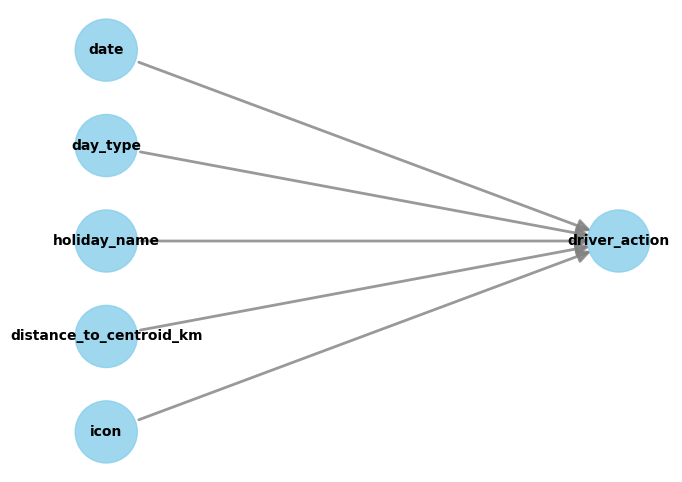

In [119]:
from dowhy import CausalModel

# Define treatment and outcome columns
treatment_col = 'day_type'
outcome_col = 'driver_action'

# Create the causal model
model5 = CausalModel(
    data=df_sample,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=g
)

# Visualize the model
model5.view_model()


In [120]:
# Identify the causal effect
identified_estimand = model5.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
───────────(E[driver_action])
d[day_type]                  
Estimand assumption 1, Unconfoundedness: If U→{day_type} and U→driver_action then P(driver_action|day_type,,U) = P(driver_action|day_type,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [122]:
# Choose the method for effect estimation
method = "backdoor.linear_regression"  # or "backdoor.propensity_score_weighting"

# Desired effect
desired_effect = "ate"

# Estimate the effect
estimate = model4.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,
    method_params={"weighting_scheme": "ips_weight"}
)

print("Causal Estimate is " + str(estimate.value))


/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimization-Deliv

Causal Estimate is 0.3908365305563029


/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimizati

In [123]:
estimate.value